# MoViNet Tutorial

This notebook provides basic example code to create, build, and run [MoViNets (Mobile Video Networks)](https://arxiv.org/pdf/2103.11511.pdf). Models use TF Keras and support inference in TF 1 and TF 2. Pretrained models are provided by [TensorFlow Hub](https://tfhub.dev/google/collections/movinet/), trained on [Kinetics 600](https://deepmind.com/research/open-source/kinetics) for video action classification.

## Setup

It is recommended to run the models using GPUs or TPUs.

To select a GPU/TPU in Colab, select `Runtime > Change runtime type > Hardware accelerator` dropdown in the top menu.

### Install the TensorFlow Model Garden pip package

- tf-models-official is the stable Model Garden package. Note that it may not include the latest changes in the tensorflow_models github repo.
- To include latest changes, you may install tf-models-nightly, which is the nightly Model Garden package created daily automatically.
pip will install all models and dependencies automatically.

Install the [mediapy](https://github.com/google/mediapy) package for visualizing images/videos.

In [1]:
!pip install -q tf-models-nightly tfds-nightly

!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 4.1 MB 45.5 MB/s 
     |████████████████████████████████| 352 kB 59.3 MB/s 
     |████████████████████████████████| 1.2 MB 46.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.3 MB/s 
     |████████████████████████████████| 636 kB 58.9 MB/s 
     |████████████████████████████████| 485.8 MB 9.3 kB/s 
     |████████████████████████████████| 47.6 MB 2.1 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 213 kB 54.7 MB/s 
     |████████████████████████████████| 99 kB 7.8 MB/s 
     |████████████████████████████████| 4.9 MB 25.9 MB/s 
     |████████████████████████████████| 90 kB 8.3 MB/s 
     |████████████████████████████████| 1.4 MB 43.1 MB/s 
     |████████████████████████████████| 462 kB 66.7 MB/s 
     |████████████████████████████████| 5.8 MB 11.5 MB/s 


In [2]:
import os
from six.moves import urllib

import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from official.vision.beta.configs import video_classification
from official.vision.beta.projects.movinet.configs import movinet as movinet_configs
from official.vision.beta.projects.movinet.modeling import movinet
from official.vision.beta.projects.movinet.modeling import movinet_layers
from official.vision.beta.projects.movinet.modeling import movinet_model

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.8.0-dev20211129). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


## Example Usage with TensorFlow Hub

Load MoViNet-A2-Base from TensorFlow Hub, as part of the [MoViNet collection](https://tfhub.dev/google/collections/movinet/).

The following code will:

- Load a MoViNet KerasLayer from [tfhub.dev](https://tfhub.dev).
- Wrap the layer in a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
- Load an example image, and reshape it to a single frame video.
- Classify the video

In [3]:
movinet_a2_hub_url = 'https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/1'

inputs = tf.keras.layers.Input(
    shape=[None, None, None, 3],
    dtype=tf.float32)

encoder = hub.KerasLayer(movinet_a2_hub_url, trainable=True)

# Important: To use tf.nn.conv3d on CPU, we must compile with tf.function.
encoder.call = tf.function(encoder.call, experimental_compile=True)

# [batch_size, 600]
outputs = encoder(dict(image=inputs))

model = tf.keras.Model(inputs, outputs)

To provide a simple example video for classification, we can load a static image and reshape it to produce a video with a single frame.

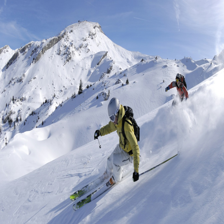

In [4]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/8/84/Ski_Famille_-_Family_Ski_Holidays.jpg'
image_height = 224
image_width = 224

with urllib.request.urlopen(image_url) as f:
  image = Image.open(f).resize((image_height, image_width))
video = tf.reshape(np.array(image), [1, 1, image_height, image_width, 3])
video = tf.cast(video, tf.float32) / 255.

image

Run the model and output the predicted label. Expected output should be skiing (labels 464-467). E.g., 465 = "skiing crosscountry".

See [here](https://gist.github.com/willprice/f19da185c9c5f32847134b87c1960769#file-kinetics_600_labels-csv) for a full list of all labels.

In [5]:
output = model(video)
output_label_index = tf.argmax(output, -1)[0].numpy()

print(output_label_index)

465


## Example Usage with the TensorFlow Model Garden

Fine-tune MoViNet-A0-Base on [UCF-101](https://www.crcv.ucf.edu/research/data-sets/ucf101/).

The following code will:

- Load the UCF-101 dataset with [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/ucf101).
- Create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline for training and evaluation.
- Display some example videos from the dataset.
- Build a MoViNet model and load pretrained weights.
- Fine-tune the final classifier layers on UCF-101.

### Load the UCF-101 Dataset with TensorFlow Datasets

Calling `download_and_prepare()` will automatically download the dataset. After downloading, this cell will output information about the dataset.

In [ ]:
dataset_name = 'ucf101'

builder = tfds.builder(dataset_name)

config = tfds.download.DownloadConfig(verify_ssl=False)
builder.download_and_prepare(download_config=config)

In [ ]:
num_classes = builder.info.features['label'].num_classes
num_examples = {
    name: split.num_examples
    for name, split in builder.info.splits.items()
}

print('Number of classes:', num_classes)
print('Number of examples for train:', num_examples['train'])
print('Number of examples for test:', num_examples['test'])
print()

builder.info

Number of classes: 101
Number of examples for train: 9537
Number of examples for test: 3783



tfds.core.DatasetInfo(
    name='ucf101',
    full_name='ucf101/ucf101_1_256/2.0.0',
    description="""
    A 101-label video classification dataset.
    """,
    config_description="""
    256x256 UCF with the first action recognition split.
    """,
    homepage='https://www.crcv.ucf.edu/data-sets/ucf101/',
    data_path='/readahead/128M/placer/prod/home/tensorflow-datasets-cns-storage-owner/datasets/ucf101/ucf101_1_256/2.0.0',
    download_size=6.48 GiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
        'video': Video(Image(shape=(256, 256, 3), dtype=tf.uint8)),
    }),
    supervised_keys=None,
    splits={
        'test': <SplitInfo num_examples=3783, num_shards=32>,
        'train': <SplitInfo num_examples=9537, num_shards=64>,
    },
    citation="""@article{DBLP:journals/corr/abs-1212-0402,
      author    = {Khurram Soomro and
                   Amir Roshan Zamir and
                   Mu

Build the training and evaluation datasets.

In [ ]:
batch_size = 8
num_frames = 8
frame_stride = 10
resolution = 172

def format_features(features):
  video = features['video']
  video = video[:, ::frame_stride]
  video = video[:, :num_frames]

  video = tf.reshape(video, [-1, video.shape[2], video.shape[3], 3])
  video = tf.image.resize(video, (resolution, resolution))
  video = tf.reshape(video, [-1, num_frames, resolution, resolution, 3])
  video = tf.cast(video, tf.float32) / 255.

  label = tf.one_hot(features['label'], num_classes)
  return (video, label)

train_dataset = builder.as_dataset(
    split='train',
    batch_size=batch_size,
    shuffle_files=True)
train_dataset = train_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(2)

test_dataset = builder.as_dataset(
    split='test',
    batch_size=batch_size)
test_dataset = test_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=True)
test_dataset = test_dataset.prefetch(2)

Display some example videos from the dataset.

In [ ]:
videos, labels = next(iter(train_dataset))
media.show_videos(videos.numpy(), codec='gif', fps=5)

### Build MoViNet-A0-Base and Load Pretrained Weights

Here we create a MoViNet model using the open source code provided in [tensorflow/models](https://github.com/tensorflow/models) and load the pretrained weights. Here we freeze the all layers except the final classifier head to speed up fine-tuning.

In [10]:
model_id = 'a0'
batch_size = 8
num_frames = 8
frame_stride = 10
resolution = 172

tf.keras.backend.clear_session()

backbone = movinet.Movinet(
    model_id=model_id)
model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=600)
model.build([batch_size, num_frames, resolution, resolution, 3])

# Load pretrained weights from TF Hub
# movinet_hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/base/kinetics-600/classification/1'
# movinet_hub_model = hub.KerasLayer(movinet_hub_url, trainable=True)
# pretrained_weights = {w.name: w for w in movinet_hub_model.weights}
# model_weights = {w.name: w for w in model.weights}
# for name in pretrained_weights:
#   model_weights[name].assign(pretrained_weights[name])

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs
model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=4)

model.build([batch_size, num_frames, resolution, resolution, 3])

# Freeze all layers except for the final classifier head
for layer in model.layers[:-1]:
  layer.trainable = False
model.layers[-1].trainable = True

In [ ]:
model.summary()

Configure fine-tuning with training/evaluation steps, loss object, metrics, learning rate, optimizer, and callbacks.

Here we use 3 epochs. Training for more epochs should improve accuracy.

In [ ]:
num_epochs = 3

train_steps = num_examples['train'] // batch_size
total_train_steps = train_steps * num_epochs
test_steps = num_examples['test'] // batch_size

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1)

metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

callbacks = [
    tf.keras.callbacks.TensorBoard(),
]

Run the fine-tuning with Keras compile/fit. After fine-tuning the model, we should be able to achieve >70% accuracy on the test set.

In [ ]:
results = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks,
    validation_freq=1,
    verbose=1)

Epoch 1/3
1192/1192 [==============================] - 348s 286ms/step - loss: 3.4914 - top_1: 0.3639 - top_5: 0.6294 - val_loss: 2.5153 - val_top_1: 0.5975 - val_top_5: 0.8565
Epoch 2/3
1192/1192 [==============================] - 286s 240ms/step - loss: 2.1397 - top_1: 0.6794 - top_5: 0.9231 - val_loss: 2.0695 - val_top_1: 0.6838 - val_top_5: 0.9070
Epoch 3/3
1192/1192 [==============================] - 348s 292ms/step - loss: 1.8925 - top_1: 0.7660 - top_5: 0.9454 - val_loss: 1.9848 - val_top_1: 0.7116 - val_top_5: 0.9227


We can also view the training and evaluation progress in TensorBoard.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 0